Deep Declarative Networks - basic examples
---
Either utilise the readme.md instructions, or for a local (cpuonly) torch install create a conda environment, and install
```
conda install pytorch torchvision torchaudio cpuonly -c pytorch
pip install -r requirements.txt
jupyter nbextension enable --py widgetsnbextension
```

At it's essence, a deep declarative node enables us to embed *optimisation* steps as a input->output node within a neural network.

The implicit function theorem enables us to differentiate the output of our optimisation, with respect to the input.

The paper https://arxiv.org/pdf/1909.04866.pdf and github https://github.com/anucvml/ddn demonstrate these more rigorously.

The biggest caveats are for
- Non-smooth objectives and constraints
- Non-regular solutions
- Non-uniique solutions
- Singular hessians

Although each has some suggested directions

In [8]:
%matplotlib inline

import autograd.numpy as np
from autograd import grad
from autograd import jacobian

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Example 1 - implicit function theorem (and autograd)

In [9]:
# Function we want to minimise (wrt u)
def f(x, u):
    """y(x) = argmin_u f(x,u) = xu^4 + 2x^2u^3 - 12u^2"""
    return x * u ** 4.0 + 2 * x ** 2.0 * u ** 3.0 - 12.0 * u ** 2.0

# the solution, from just equating d/du f(x,u) = 0
def solve(x):
    delta = np.sqrt(9.0 * x ** 4.0 + 96.0 * x)
    y_stationary = [0.0, (-3.0 * x ** 2.0 - delta) / (4.0 * x), (-3.0 * x ** 2.0 + delta) / (4.0 * x)]
    y_min_indx = np.argmin([f(x, y) for y in y_stationary])
    return y_stationary[y_min_indx]

In [10]:
# Generate dataset
x = np.linspace(0.25, 2.25, 101)
u = np.linspace(-6.0, 4.0, 101)

In [14]:
def gradient_by_closed_form(x):
    """Compute the gradient using the closed-form expression."""
    delta = np.sqrt(9.0 * x ** 4 + 96.0 * x)
    return -0.75 - (9.0 * x ** 3 - 48.0) / (4 * x * delta)

def gradient_by_ift(x, y):
    """Compute the gradient using the implicit function theorem result."""
    return -1.0 * (y ** 3 + 3.0 * x * y ** 2) / (3.0 * x * y ** 2 + 3.0 * x ** 2 * y - 6.0)

y = [solve(xi) for xi in x]

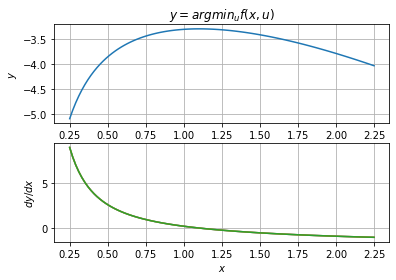

In [15]:
def f(x, u):
    return x * np.power(u, 4.0) + 2 * np.power(x, 2.0) * np.power(u, 3.0) - 12.0 * np.power(u, 2.0)

def gradient_by_auto_diff(x, y):
    fY = grad(f, 1)
    fXY = jacobian(fY, 0)
    fYY = jacobian(fY, 1)

    return -1.0 * fXY(x, y) / fYY(x, y)

plt.figure()
plt.subplot(2, 1, 1); plt.plot(x, y); plt.grid()
plt.title(r'$y = argmin_u f(x, u)$'); plt.ylabel(r'$y$')

plt.subplot(2, 1, 2); 
# Shows all the gradients are equal! Therefore implicit function theorem and autograd all work nicely!
plt.plot(x, [gradient_by_auto_diff(xi, yi) for xi, yi in zip(x, y)]); plt.grid()
plt.plot(x, [gradient_by_closed_form(xi) for xi in x])
plt.plot(x, [gradient_by_ift(xi, yi) for xi, yi in zip(x, y)])
plt.xlabel(r'$x$'); plt.ylabel(r'$dy/dx$')

plt.show()

# Example 2 - pytorch ddn node
This creates a pytorch node (which can be used in the forward pass) and automatically computes gradients for the backwards pass in [DDN library](https://github.com/anucvml/ddn/)

DDN nodes to inherit from:
- AbstractDeclarativeNode 
```
    minimize (over y) f(x, y)
```
- EqConstDeclarativeNode
```
    minimize (over y) f(x, y)
    subject to  h_i(x, y) = 0
```
- IneqConstDeclarativeNode
```
    minimize (over y) f(x, y)
    subject to  h_i(x, y) = 0
                g_i(x, y) <= 0
```
- LinEqConstDeclarativeNode
```
    minimize (over y) f(x, y)
    subject to  A y = d
```

Each [node](https://github.com/anucvml/ddn/blob/master/ddn/pytorch/node.py) needs: 
- **objective function** f(x,y)
```python
def objective(self, x, y):
    return ...
```
- optional constraints (if problem is constrained)
```python
def equality_constraints(self, *xs, y):
    return ...
```
```python
def inequality_constraints(self, *xs, y):
    return ...
```
- **solve** (returns solution y, context for computing gradient (optional)
```python
def solve(self, *xs):
    return ..., ...
```

plus, if you have an efficient gradient calculation
- you may also override the gradient function
```python
def gradient(self, *xs, y=None, v=None, ctx=None):
    return ...
```

For unconstrained you can utilise 
- torch.optim 
To solve for for constrained scalar problems you can utilise
- scipy.minimize

Scipy potentially needs to be used with 1.4.1 or it may crash? (unknown issue)

The following is an example of scipy.optimize for a linearly constrained problem

In [19]:
# A simple example, utilising pytorch
#####################################

import torch
import numpy as np
import scipy.optimize as opt
from ddn.pytorch.node import *

# create the example node
class MinKL(LinEqConstDeclarativeNode):
    def __init__(self):
        super().__init__()

    def objective(self, x, y):
        """f(x, y) = -sum x*log(y)"""
        return -1.0 * torch.einsum('bn,bn->b', (x, y.log()))
    
    def linear_constraint_parameters(self, y):
        """Ay=d ==> sum(y) = 1"""
        A = y.new_ones(1, y.size(-1)) # 1xm
        d = y.new_ones(1) # 1
        return A, d
        
    def solve(self, x):
        """Solve the constrained optimization problem using scipy's built-in minimize function.
        Here we initialize the solver at the uniform distribution.
        """
        m = n = x.size(-1)
        u0 = np.ones((m,)) / m
        y = torch.zeros_like(x)
        # Loop over batch:
        for i, xi in enumerate(x):
            result = opt.minimize(lambda u: -1.0 * np.dot(xi.detach().numpy(), np.log(u)),
                                  u0,
                                  constraints={'type': 'eq', 'fun': lambda u: np.sum(u) - 1.0},
                                  bounds=opt.Bounds(1e-12, np.inf, keep_feasible=True),
                                  options={'maxiter': 100000, 'ftol': 1e-12})
            y[i, :] = torch.tensor(result.x)
        
        # The solve function must always return two arguments, the solution and context (i.e., cached values needed
        # for computing the gradient). In the case of linearly constrained problems we do not need the dual solution
        # in computing the gradient so we return None for context.
        return y, None

In [18]:
node = MinKL()
x = torch.rand(1, 5)
print("Input:\n{}".format(x.squeeze().numpy()))
print("Expected output:\n{}".format((x / x.sum(dim=-1, keepdim=True)).squeeze().numpy()))

y, _ = node.solve(x)
print("Actual output:\n{}".format(y.squeeze().numpy()))

Input:
[0.22006702 0.8772989  0.5509969  0.17108011 0.97609276]
Expected output:
[0.07872088 0.3138214  0.19709887 0.06119762 0.34916127]
Actual output:
[0.07872087 0.3138214  0.19709885 0.0611976  0.34916127]


See https://nbviewer.org/github/anucvml/ddn/tree/master/tutorials/ for the original authors full set of tutorials